In [320]:
import pandas as pd
import geopandas as gpd #allows for world map overlay
from shapely.geometry import Polygon

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors

import tkinter as tk
from tkinter import simpledialog, messagebox

import fsspec
from datetime import datetime
from shapely.geometry import box
# -------------------------------------------------------------------
# Things to adjust:
# need to make sure that all heatmaps can revert back to the selection screen // done
# maybe change the color of the oceans/water and ground (easier viewing) // not implemented
# need to find a way to adjust the heatmap from data to display at the right size for the selection // done
# need to display the different overlap layers in different colors (as a genuine heatmap) with an accurate legend. // done
# need to add in the option to sort the data by date and display the heatmap as well. // done
# -------------------------------------------------------------------

In [321]:
# -------------------------------------------------------------------
# World Map Overlay
# -------------------------------------------------------------------
# Function to plot world map outline

url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/110m_cultural.zip"

def plot_world_map(ax):    
    with fsspec.open(f"simplecache::{url}") as file:
        world = gpd.read_file(file)
    #world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

In [324]:
%%time
df = pd.read_csv('coordinates_dates_2022.csv')
df['geometry'] = df.apply(lambda row: Polygon([
    (row['coordinate1_lon'], row['coordinate1_lat']),
    (row['coordinate2_lon'], row['coordinate2_lat']),
    (row['coordinate3_lon'], row['coordinate3_lat']),
    (row['coordinate4_lon'], row['coordinate4_lat']),
    (row['coordinate5_lon'], row['coordinate5_lat']),
]), axis=1)

CPU times: total: 11 s
Wall time: 25.4 s


In [319]:
%%time
#NEED TO MAKE SURE THAT WHEN THIS FIGURE IS DONE, WE CAN EXIT THE PROGRAM!

# -------------------------------------------------------------------
# Full World Heatmap function
def full_world_heatmap():
    csv_file_path = 'polygon_only_2022.csv'

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file_path)

    # Convert the pandas DataFrame to a GeoPandas DataFrame
    gdf = gpd.GeoDataFrame(df)
    # Define the number of divisions in the grid
    divisions = 150
    # Define custom colors based on the number of data points
    colors = ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026']
    cmap = ListedColormap(colors)

    boundaries = [0, 1, 25, 50, 100, 250, 500, 1000, 3000]

    # Create a BoundaryNorm for the colorbar
    norm = BoundaryNorm(boundaries, len(colors), clip=True)

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(12, 10))

    # Overlay world map outline
    plot_world_map(ax)

    # Invert the heatmap data vertically
    heatmap_data = np.flipud(gdf['count'].values.reshape(divisions, divisions))

    # Plot the heatmap with custom colors
    heatmap = ax.imshow(heatmap_data, cmap=cmap, norm=norm, extent=[-180, 180, -90, 90])  

    # Create the colorbar with discrete blocks
    colorbar = plt.colorbar(heatmap, boundaries=boundaries[:-1], ticks=boundaries[:-1], extend='max', shrink=0.5)

    # Set the colorbar labels
    colorbar_labels = ['<= 1', '2 - 25', '26 - 50', '51 - 100', '101 - 250', '251 - 500', '501 - 1000', '> 1000']
    colorbar.ax.set_yticklabels(colorbar_labels)

    # Set the title and labels
    ax.set_title("Full World Heatmap", fontsize=20, fontweight='bold')
    ax.set_xlabel("Longitude", fontsize=16)
    ax.set_ylabel("Latitude", fontsize=16)
    
    # Add gridlines to the heatmap
    ax.grid(which='both', linestyle='--', linewidth=0.5, color='gray')

    # Save and show the image
    plt.savefig('heatmap_full_year_2022.png')
    #plt.show(block=False)
    display_heatmap()
    root.destroy()

CPU times: total: 0 ns
Wall time: 0 ns


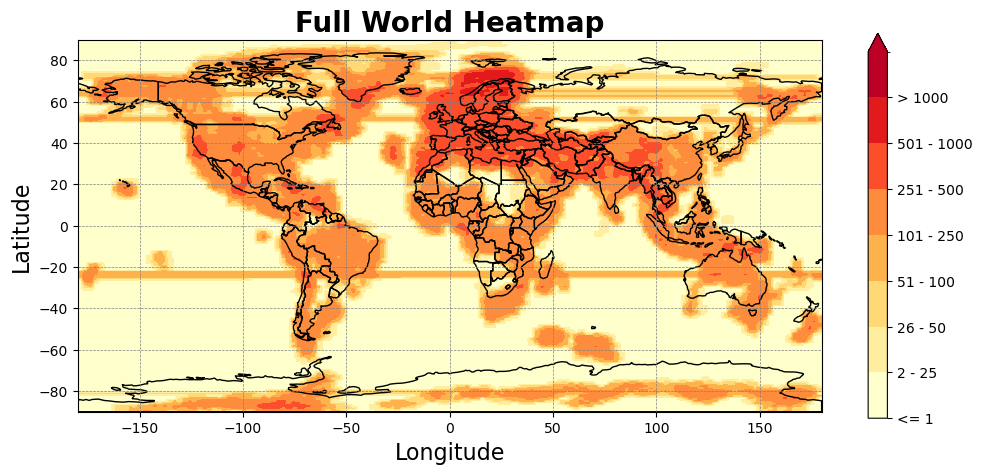

CPU times: total: 3.09 s
Wall time: 7.43 s


In [332]:
%%time
full_world_heatmap()

In [313]:
# -------------------------------------------------------------------
# Heatmap Functions
# -------------------------------------------------------------------
# Heatmap() function for generating custom-colored heatmaps
#this is for the custom heatmaps
def Heatmaps(start_date, end_date, min_lat, max_lat, min_lon, max_lon):
    # Convert user input to datetime strings
    start_date_str = start_date + 'T00:00:00.000Z'
    end_date_str = end_date + 'T23:59:59.999Z'

    # Filter data based on user-provided latitude and longitude range
    #filtered_df = df[(df['coordinate1_lat'] >= min_lat) & (df['coordinate1_lat'] <= max_lat) &
    #                 (2*df['coordinate1_lon'] >= min_lon) & (2*df['coordinate1_lon'] <= max_lon)]
    
    #filtered_df = df[(df['coordinate1_lat'] >= min_lat) & (df['coordinate1_lat'] <= max_lat) &
    #                 (df['coordinate1_lon'] >= min_lon) & (df['coordinate1_lon'] <= max_lon) &
    #                (df['coordinate2_lat'] >= min_lat) & (df['coordinate2_lat'] <= max_lat) &
    #                 (df['coordinate2_lon'] >= min_lon) & (df['coordinate2_lon'] <= max_lon) &
    #                (df['coordinate3_lat'] >= min_lat) & (df['coordinate3_lat'] <= max_lat) &
    #                 (df['coordinate3_lon'] >= min_lon) & (df['coordinate3_lon'] <= max_lon) &
    #                (df['coordinate4_lat'] >= min_lat) & (df['coordinate4_lat'] <= max_lat) &
    #                 (df['coordinate4_lon'] >= min_lon) & (df['coordinate4_lon'] <= max_lon) &
    #                (df['coordinate5_lat'] >= min_lat) & (df['coordinate5_lat'] <= max_lat) &
    #                 (df['coordinate5_lon'] >= min_lon) & (df['coordinate5_lon'] <= max_lon) &
    #                (df['start date'] >= start_date_str) & (df['start date'] <= end_date_str)]
                     
    # Filter the DataFrame based on date range
    filtered_df = df[(df['start date'] >= start_date_str) & (df['start date'] <= end_date_str)]
    
    # Create a GeoDataFrame from the DataFrame
    new_gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry')
    
    minx, miny, maxx, maxy = new_gdf.total_bounds
    width = maxx - minx
    height = maxy - miny

    # Define the number of divisions in the grid
    divisions = 150
    # Initialize an empty list to hold the data dictionaries
    custom_data_list = []

    # Populate the list with counts
    for i in range(divisions):
        for j in range(divisions):
            # Define the corners of the grid cell
            cell_minx = minx + i * (width / divisions)
            cell_miny = miny + j * (height / divisions)
            cell_maxx = minx + (i + 1) * (width / divisions)
            cell_maxy = miny + (j + 1) * (height / divisions)
            cell = Polygon([(cell_minx, cell_miny), (cell_maxx, cell_miny), (cell_maxx, cell_maxy), (cell_minx, cell_maxy)])
            count = new_gdf[new_gdf.geometry.intersects(cell)].shape[0]
            custom_data_list.append({'geometry': cell, 'count': count})

    # Convert the list of dictionaries to a DataFrame
    custom_data_df = pd.DataFrame(custom_data_list)
    
    # Define custom colors based on the number of data points
    colors = ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026']
    cmap = ListedColormap(colors)

    boundaries = [0, 1, 25, 50, 100, 250, 500, 1000, 3000]

    # Create a BoundaryNorm for the colorbar
    norm = BoundaryNorm(boundaries, len(colors), clip=True)

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(12, 10))

    # Overlay world map outline
    plot_world_map(ax)

    # Invert the heatmap data vertically
    heatmap_data = np.flipud(custom_data_df['count'].values.reshape(divisions, divisions))

    # Plot the heatmap with custom colors
    heatmap = ax.imshow(heatmap_data, cmap=cmap, norm=norm, extent=[-180, 180, -90, 90]) 
    #heatmap = ax.imshow(custom_data_df['count'].values.reshape(divisions, divisions), cmap=cmap, norm=norm, 
    #                    extent=[min_lon, max_lon, min_lat, max_lat]) 

    # Create the colorbar with discrete blocks
    colorbar = plt.colorbar(heatmap, boundaries=boundaries[:-1], ticks=boundaries[:-1], extend='max', shrink=0.5)

    # Set the colorbar labels
    colorbar_labels = ['<= 1', '2 - 25', '26 - 50', '51 - 100', '101 - 250', '251 - 500', '501 - 1000', '> 1000']
    colorbar.ax.set_yticklabels(colorbar_labels)

    # Manually set up the axis range because the extent in heatmap was not working properly to show this range
    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)

    # Set axis labels
    ax.set_title('Requested Heatmap', fontsize=20, fontweight='bold')
    ax.set_xlabel('Longitude', fontsize=16)
    ax.set_ylabel('Latitude', fontsize=16)
    
    # Add gridlines to the heatmap
    ax.grid(which='both', linestyle='--', linewidth=0.5, color='gray')

    # Save and show the image
    plt.savefig('heatmap_with_world_map_specific_date_coords.png')
    plt.show()
    #display_heatmap()
    root.destroy()

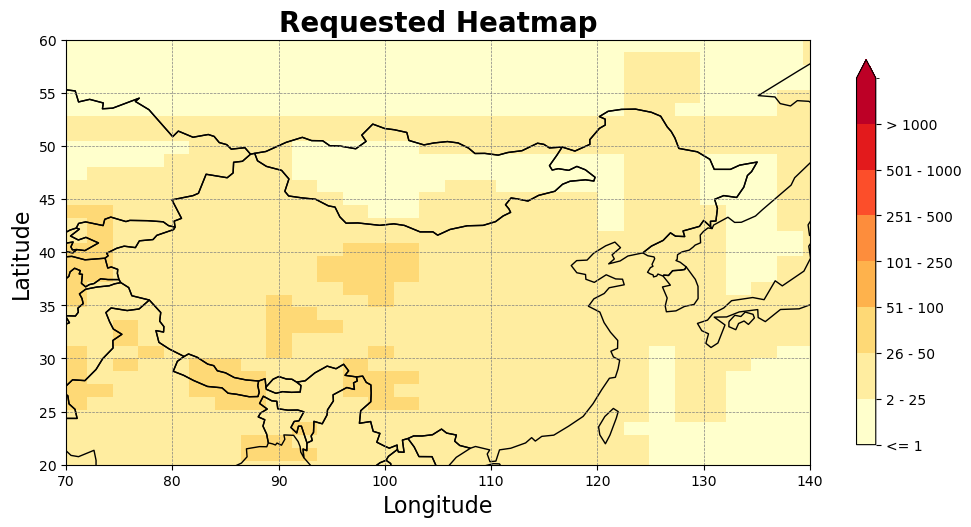

CPU times: total: 49.9 s
Wall time: 2min 7s


In [304]:
%%time
Heatmaps("2022-01-01", "2022-01-30", 20, 60, 70, 140)

In [333]:
# Function to handle the Generate Heatmap Using Date Range
def date_generate_heatmap(start_date, end_date):
    # Convert user input to datetime strings
    start_date_str = start_date + 'T00:00:00.000Z'
    end_date_str = end_date + 'T23:59:59.999Z'

    # Filter the DataFrame based on date range
    filtered_df = df[(df['start date'] >= start_date_str) & (df['start date'] <= end_date_str)]
    
    # Create a GeoDataFrame from the DataFrame
    gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry')
    
    minx, miny, maxx, maxy = gdf.total_bounds
    width = maxx - minx
    height = maxy - miny

    # Define the number of divisions in the grid
    divisions = 150    
    
    # Initialize an empty list to hold the data dictionaries
    custom_data_list = []

    # Populate the list with counts
    for i in range(divisions):
        for j in range(divisions):
            # Define the corners of the grid cell
            cell_minx = minx + i * (width / divisions)
            cell_miny = miny + j * (height / divisions)
            cell_maxx = minx + (i + 1) * (width / divisions)
            cell_maxy = miny + (j + 1) * (height / divisions)
            cell = Polygon([(cell_minx, cell_miny), (cell_maxx, cell_miny), (cell_maxx, cell_maxy), (cell_minx, cell_maxy)])
            count = gdf[gdf.geometry.intersects(cell)].shape[0]
            custom_data_list.append({'geometry': cell, 'count': count})
   
    # Convert the list of dictionaries to a DataFrame
    custom_data_df = pd.DataFrame(custom_data_list)
    
    # Define custom colors based on the number of data points
    colors = ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026']
    cmap = ListedColormap(colors)

    boundaries = [0, 1, 25, 50, 100, 250, 500, 1000, 3000]

    # Create a BoundaryNorm for the colorbar
    norm = BoundaryNorm(boundaries, len(colors), clip=True)

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(12, 10))

    # Overlay world map outline
    plot_world_map(ax)

    # Invert the heatmap data vertically
    heatmap_data = np.flipud(custom_data_df['count'].values.reshape(divisions, divisions))

    # Plot the heatmap with custom colors
    heatmap = ax.imshow(heatmap_data, cmap=cmap, norm=norm, extent=[-180, 180, -90, 90])  

    # Create the colorbar with discrete blocks
    colorbar = plt.colorbar(heatmap, boundaries=boundaries[:-1], ticks=boundaries[:-1], extend='max', shrink=0.5)

    # Set the colorbar labels
    colorbar_labels = ['<= 1', '2 - 25', '26 - 50', '51 - 100', '101 - 250', '251 - 500', '501 - 1000', '> 1000']
    colorbar.ax.set_yticklabels(colorbar_labels)

    # Set the title and labels
    ax.set_title("Requested World Heatmap", fontsize=20, fontweight='bold')
    ax.set_xlabel("Longitude", fontsize=16)
    ax.set_ylabel("Latitude", fontsize=16)
    
    # Add gridlines to the heatmap
    ax.grid(which='both', linestyle='--', linewidth=0.5, color='gray')

    # Save and show the image
    plt.savefig('heatmap_with_world_map_specific_date.png')
    plt.show()
    #display_heatmap()
    root.destroy()

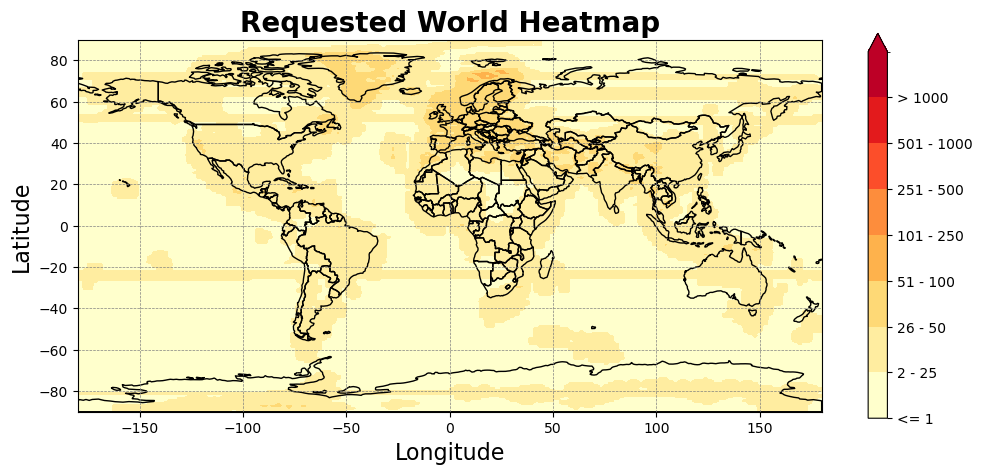

TclError: can't invoke "destroy" command: application has been destroyed

In [334]:
%%time
date_generate_heatmap("2022-01-01", "2022-01-30");

In [316]:
# -------------------------------------------------------------------
# Country Display function
# -------------------------------------------------------------------

# Function to display a country on a world map
def get_country_bounds(country_name):
    url_countries = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip"
    with fsspec.open(f"simplecache::{url_countries}") as file:
        world = gpd.read_file(file)
    country = world[world['NAME'] == country_name]

    # error handling stuff...
    if country.empty:
        raise ValueError(f"Country '{country_name}' not found in dataset.")
        
    # Get the bounding box of the country
    minx, miny, maxx, maxy = country.total_bounds
    return miny, maxy, minx, maxx

def display_country(country_name, start_date, end_date):
    # passing in the bounds of the country:
    min_lat, max_lat, min_lon, max_lon = get_country_bounds(country_name)
    Heatmaps(start_date, end_date, min_lat, max_lat, min_lon, max_lon)

In [242]:
get_country_bounds("United States of America")

(18.91619, 71.35776357694175, -171.79111060289122, -66.96465999999998)

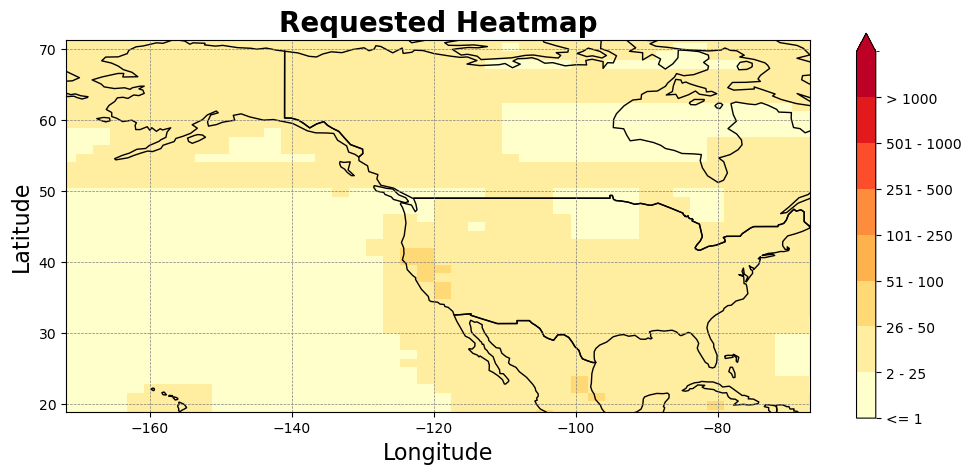

CPU times: total: 50.4 s
Wall time: 2min 32s


In [295]:
%%time
display_country("United States of America", "2022-01-01", "2022-01-30")

In [328]:
# -------------------------------------------------------------------
# User Interfacing Functions - Button Implements
# -------------------------------------------------------------------    
# Function to handle the "Exit" button
def exit_program():
    root.destroy()  # Close the main window

# Function to handle the "Not Implemented" button
def not_implemented():
    messagebox.showinfo("Info", "This has yet to be implemented!")
    root.destroy()  # Close the main window

# -------------------------------------------------------------------
# User Infercaing Functions - Windows
# -------------------------------------------------------------------

# Function to create a custom dialog for selecting options
def choose_option_dialog():    
    dialog = tk.Toplevel()
    dialog.title("ASF Heatmap Application")

    # Label
    label = tk.Label(dialog, text="Select an option:")
    label.pack(pady=10)

    # Button for Display Country on World Map
    btn_country = tk.Button(dialog, text="Display Country on World Map", command=lambda: display_country_dialog(dialog))
    btn_country.pack(pady=5) #lambda: display_country_dialog(dialog) is what was used in command above

    # Button for Generate Heatmap
    # btn_heatmap = tk.Button(dialog, text="Generate Custom Heatmap", command=lambda: generate_heatmap_dialog(dialog))
    # btn_heatmap.pack(pady=5)
    
    # Button for Generate Custom Heatmap Using Dates
    btn_date_heatmap = tk.Button(dialog, text="Generate Custom Heatmap Using Dates", 
                                 command=lambda: date_heatmap_dialog(dialog))
    btn_date_heatmap.pack(pady=5)
    
    # Button for Generate Custom Heatmap Using Coordinates
    btn_coordinate_heatmap = tk.Button(dialog, text="Generate Custom Heatmap Using Dates and Coordinates", 
                                       command=lambda: generate_heatmap_dialog(dialog))
    btn_coordinate_heatmap.pack(pady=5)

    # Button for Full World Heatmap
    # This one doesn't need a interface function
    btn_full_world_heatmap = tk.Button(dialog, text="Full World Heatmap", command=lambda: full_world_heatmap())
    btn_full_world_heatmap.pack(pady=5)

    # Button for "Exit"
    btn_exit = tk.Button(dialog, text="Exit", command=exit_program)
    btn_exit.pack(pady=5)

# -------------------------------------------------------------------
# User Interfacing Functions - Heatmap generation with UI
# -------------------------------------------------------------------

# Function to handle the Display Country on World Map option
def display_country_dialog(dialog):
    dialog.destroy()
    country_name = simpledialog.askstring("Input", "Enter the country name:")
    start_date = simpledialog.askstring("Input", "Enter the start date (YYYY-MM-DD):")
    end_date = simpledialog.askstring("Input", "Enter the end date (YYYY-MM-DD):")

    # Convert input strings to datetime objects
    #start_date = datetime.strptime(start_date_query, '%Y-%m-%d')
    #end_date = datetime.strptime(end_date_query, '%Y-%m-%d')
    display_country(country_name, start_date, end_date)

# Function to handle the Generate Heatmap Using Coordinates
def generate_heatmap_dialog(dialog):
    dialog.destroy()
    start_date = simpledialog.askstring("Input", "Enter the start date (YYYY-MM-DD):")
    end_date = simpledialog.askstring("Input", "Enter the end date (YYYY-MM-DD):")
    min_lat = simpledialog.askfloat("Input", "Enter the minimum latitude:")
    max_lat = simpledialog.askfloat("Input", "Enter the maximum latitude:")
    min_lon = simpledialog.askfloat("Input", "Enter the minimum longitude:")
    max_lon = simpledialog.askfloat("Input", "Enter the maximum longitude:")
    Heatmaps(start_date, end_date, min_lat, max_lat, min_lon, max_lon)

# Function to handle the Generate Heatmap Using Dates
def date_heatmap_dialog(dialog):
    dialog.destroy()
    start_date = simpledialog.askstring("Input", "Enter the start date (YYYY-MM-DD):")
    end_date = simpledialog.askstring("Input", "Enter the end date (YYYY-MM-DD):")

    # Convert input strings to datetime objects
    #start_date = datetime.strptime(start_date_query, '%Y-%m-%d')
    #end_date = datetime.strptime(end_date_query, '%Y-%m-%d')

    # Generate the heatmap using the filtered DataFrame
    date_generate_heatmap(start_date, end_date)


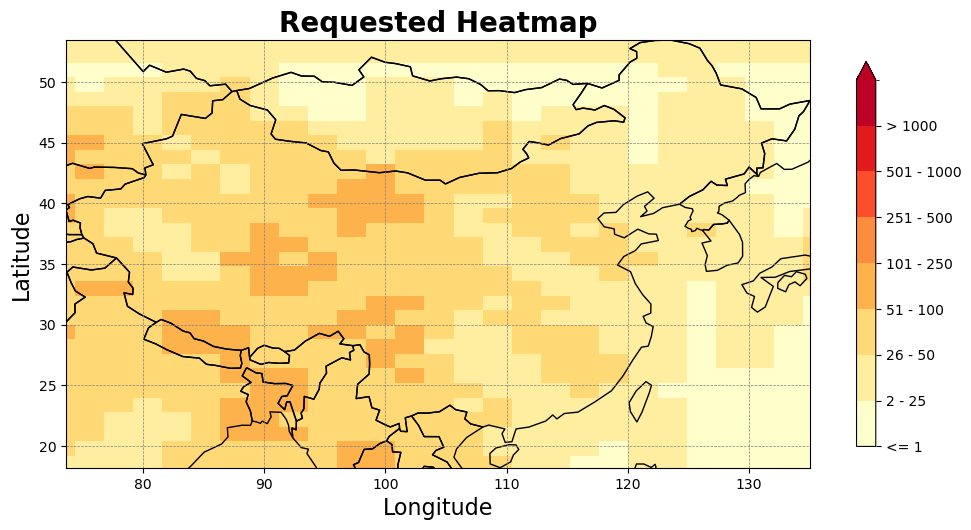

KeyboardInterrupt: 

In [330]:
# -------------------------------------------------------------------
# Window Creation with Tkinter
# -------------------------------------------------------------------

# Create a Tkinter window for user input
root = tk.Tk()

# Set the size of the Tkinter window (width x height)
root.geometry("500x300")

# Hide the main window
root.withdraw()

# Call the function to choose the display option
choose_option_dialog()

# Start the Tkinter event loop
root.mainloop()